# Test 2D CAE

2D CNN-based AE (CAE) have shown remarkable results for image data, e.g., MNIST. In this notebook I am testing if a 2D CAE with a similar architecture to the CAE that shows favorable results for MNIST (https://blog.keras.io/building-autoencoders-in-keras.html).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
import warnings
import matplotlib.pyplot as plt

# Ignore warnings. They just pollute the output
warnings.filterwarnings('ignore')

# Allow importing from parent directories
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

assembly = 'hg19'
window_size = 2400
step_size = window_size / 2
aggregation = 100
chroms = ['chr1', 'chr22']

## Load the data

#### Download dataset

In [3]:
import wget
from pathlib import Path

Path('data').mkdir(parents=True, exist_ok=True) 

print('Download data...')

# GM12878 ChIP-seq H3K27ac log10 p-val
bw = 'data/ENCFF258KTL.bigWig'
if not Path(bw).is_file():
    wget.download(
        'https://www.encodeproject.org/files/ENCFF258KTL/@@download/ENCFF258KTL.bigWig',
        'data/ENCFF258KTL.bigWig',
    )

print('Done!')

Download data...
Done!


#### Retrieved binned genomic windows

In [5]:
"""Chunk up the bigWig file"""

from ae import bigwig

data_train, data_test = bigwig.chunk(
    bw,
    window_size,
    step_size,
    aggregation,
    chroms,
    verbose=True,
)

Chrom: chr1 # win: 207708 Max:   168.2037875366211
Chrom: chr22 # win: 42753 Max:   194.40118530273438


#### Normalize the data

The data is capped at the 99.9th percentile and normalized to `[0, 1]`.

In [15]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

cutoff = np.percentile(data_train, (0, 99.9))
data_train_norm = np.copy(data_train)
data_train_norm[np.where(data_train_norm < cutoff[0])] = cutoff[0]
data_train_norm[np.where(data_train_norm > cutoff[1])] = cutoff[1]

cutoff = np.percentile(data_test, (0, 99.9))
data_test_norm = np.copy(data_test)
data_test_norm[np.where(data_test_norm < cutoff[0])] = cutoff[0]
data_test_norm[np.where(data_test_norm > cutoff[1])] = cutoff[1]

print('Train max: {} | Train norm max: {}'.format(np.max(data_train), np.max(data_train_norm)))
print('Test max:  {} | Test norm max: {}'.format(np.max(data_test), np.max(data_test_norm)))

data_train_norm = MinMaxScaler().fit_transform(data_train_norm)
data_test_norm = MinMaxScaler().fit_transform(data_test_norm)

Train max: 168.2037875366211 | Train norm max: 35.221359405517575
Test max:  194.40118530273438 | Test norm max: 35.95303882598877


#### Convert the 1D data into 2D bar chart images with 1 channel

In [9]:
from ae.utils import to_2d

ydim = 12
val_max = 1.0
dtype = np.float32

data_2d_train_norm = to_2d(data_train_norm, ydim, val_max, dtype)
data_2d_test_norm = to_2d(data_test_norm, ydim, val_max, dtype)

Using TensorFlow backend.


<Figure size 1440x144 with 0 Axes>

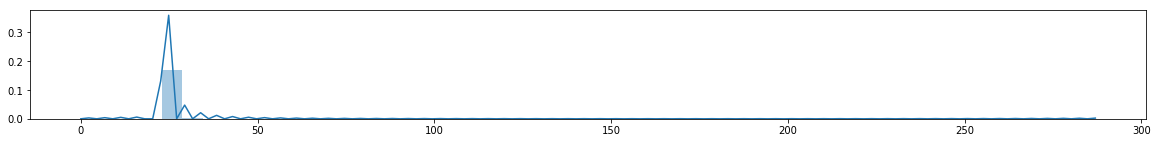

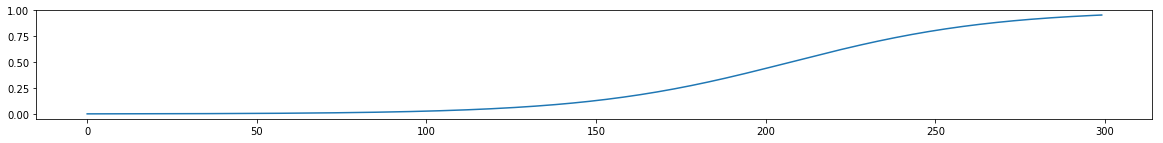

<Figure size 1440x144 with 0 Axes>

In [10]:
import seaborn as sns

signal = np.sum(
    data_2d_train_norm.reshape(data_2d_train_norm.shape[0], data_2d_train_norm.shape[1] * data_2d_train_norm.shape[2]),
    axis=1
)

def logistic(x):
    return 1 / (1 + 1000 * np.exp(-x / 30))

plt.figure(figsize=(20, 2))
sns.distplot(signal)
plt.figure(figsize=(20, 2))
plt.plot(logistic(np.arange(300)))

sample_weights = logistic(signal)
plt.figure(figsize=(20, 2))

#### Plot the 10 windows with the highest amount of signal

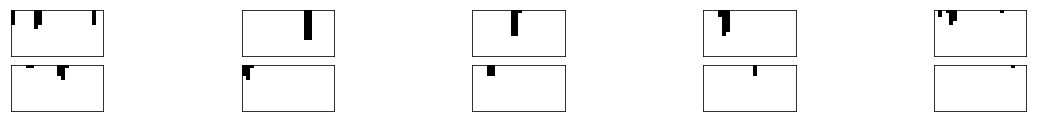

In [12]:
import matplotlib.pyplot as plt

offset = np.argsort(signal[np.where(signal > threshold)])[-10:]
n = 10

plt.figure(figsize=(20, n))
for i, k in enumerate(offset):
    # display original
    ax = plt.subplot(n, 5, i + 1)
    plt.imshow(data_2d_train_norm_sub[k], cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Build the 2D CAE

The architecture is similar to the CAE used for MNIST (https://blog.keras.io/building-autoencoders-in-keras.html).

In [46]:
from ae.cnn import cae2d

encoder, decoder, autoencoder = cae2d(
    (ydim, window_size // aggregation, 1),
    optimizer='adadelta',
    loss='binary_crossentropy',
    summary=True
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoded_input (InputLayer)   (None, 48, 24, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 24, 12, 32)        832       
_________________________________________________________________
conv2 (Conv2D)               (None, 12, 6, 64)         51264     
_________________________________________________________________
conv3 (Conv2D)               (None, 6, 3, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               1180160   
_________________________________________________________________
fc2 (Dense)                  (None, 256)               131328    
__________

## Train the model

In [47]:
from ae.utils import train

train(
    autoencoder,
    data_2d_train_norm_sub.reshape((
        data_2d_train_norm_sub.shape[0],
        data_2d_train_norm_sub.shape[1],
        data_2d_train_norm_sub.shape[2],
        1
    )),
    data_2d_test_norm.reshape(
        data_2d_test_norm.shape[0],
        data_2d_test_norm.shape[1],
        data_2d_test_norm.shape[2],
        1
    ),
    epochs=15,
    batch_size=256,
)

Train on 2163 samples, validate on 42753 samples
Epoch 1/15
2163/2163 [==============================] - 28s 13ms/step - loss: 0.6903 - val_loss: 0.6763
Epoch 2/15
2163/2163 [==============================] - 33s 15ms/step - loss: 0.6791 - val_loss: 0.6337
Epoch 3/15
2163/2163 [==============================] - 34s 16ms/step - loss: 0.6500 - val_loss: 0.5137
Epoch 4/15
2163/2163 [==============================] - 35s 16ms/step - loss: 0.6072 - val_loss: 0.3861
Epoch 5/15
2163/2163 [==============================] - 37s 17ms/step - loss: 0.5943 - val_loss: 0.3634
Epoch 6/15
2163/2163 [==============================] - 36s 17ms/step - loss: 0.5901 - val_loss: 0.3578
Epoch 7/15
2163/2163 [==============================] - 40s 18ms/step - loss: 0.5858 - val_loss: 0.3502
Epoch 8/15
2163/2163 [==============================] - 39s 18ms/step - loss: 0.5806 - val_loss: 0.3457
Epoch 9/15
2163/2163 [==============================] - 37s 17ms/step - loss: 0.5737 - val_loss: 0.3418
Epoch 10/15
216

## Predict genomic windows and get the prediction loss

In [48]:
from keras.metrics import binary_crossentropy
from ae.utils import predict_2d

predicted, loss, encoded = predict_2d(
    encoder,
    decoder,
    data_2d_test_norm.reshape(
        data_2d_test_norm.shape[0],
        data_2d_test_norm.shape[1],
        data_2d_test_norm.shape[2],
        1
    ),
    validator=binary_crossentropy
)

## Compare predictions against the ground truth

The groundtruth is plotted in black and white. The predictions are plotted in a red colormap.

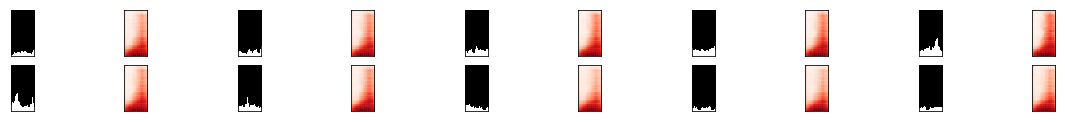

In [70]:
import matplotlib.pyplot as plt

ymax = 1.0
offset = np.arange(3809, 3827) # 2011: good to bad
offset = np.arange(32370, 32380)
n = offset.size

plt.figure(figsize=(20, n))
for i, k in enumerate(offset):
    # display original
    ax = plt.subplot(n, 10, i * 2 + 1)
    plt.imshow(data_2d_test_norm[k], cmap="gray", interpolation='nearest')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(n, 10, i * 2 + 2)
    plt.imshow(predicted[k], cmap="Reds", interpolation='nearest')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

---

## As a sanity check: run a very similar CAE against MNIST

In [296]:
from keras.datasets import mnist

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

from ptfind.nn import cae2d

encoder, decoder, autoencoder = cae2d(
    (28, 28, 1),
    filters=[32, 64, 128, 10],
    kernel_sizes=[5, 5, 3],
    optimizer='adadelta',
    loss='mse',
    summary=True
)

autoencoder.fit(
    x_train, x_train,
    epochs=25,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test, x_test),
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoded_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 14, 14, 32)        832       
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 7, 64)          51264     
_________________________________________________________________
conv3 (Conv2D)               (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
embed (Dense)                (None, 10)                11530     
_________________________________________________________________
deembed (Dense)              (None, 1152)              12672     
__________

#### Visualize the predictions on MNIST

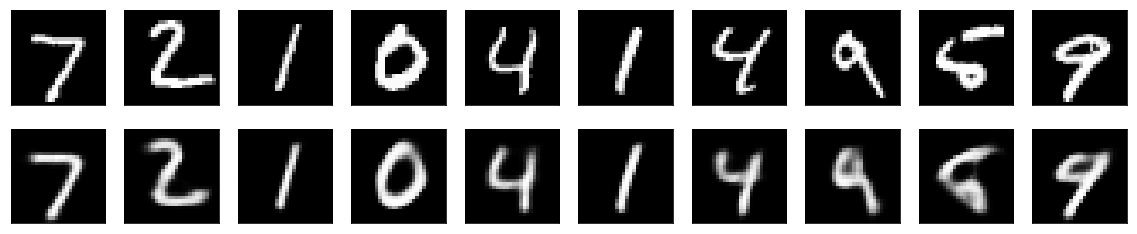

In [297]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()